# Proyecto 3 — RAG con SQuAD (Retrieval con Annoy)

Armar un RAG simple que recupere contextos con **Annoy** y responda con un modelo QA.



## 0) Instalación (este kernel)

In [1]:
# Desactivar TensorFlow para evitar conflictos con Keras 3 (solo este notebook)
import os
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['USE_TF'] = '0'

# Instalar librerías necesarias en este kernel
%pip install -qU sentence-transformers transformers datasets scikit-learn tqdm matplotlib pandas annoy

Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: Building 'annoy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'annoy'. Discussion can be found at https://github.com/pypa/pip/issues/6334


## 1) Imports y carpetas

In [2]:
import os, time, json, warnings, re
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import pipeline

from annoy import AnnoyIndex  # ← Retrieval con Annoy

warnings.filterwarnings('ignore')

# Carpetas para resultados
os.makedirs('../results/3_rag_qa', exist_ok=True)

# Dispositivo (opcional: QA puede correr en CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Usando dispositivo:', device)

Usando dispositivo: cpu


## 2) Dataset SQuAD pequeño

In [3]:
# Cargar SQuAD v1.1 (train) y tomar un subset pequeño para la demo
N = 200  # podés subir si tu PC lo permite
raw_train = load_dataset('squad')['train']

def to_row(ex):
    return {
        'title': ex['title'],
        'context': ex['context'],
        'question': ex['question'],
        'answer_text': ex['answers']['text'][0] if ex['answers']['text'] else ''
    }

small = raw_train.shuffle(seed=42).select(range(N)).map(to_row, remove_columns=raw_train.column_names)
df_small = pd.DataFrame(small)
print(df_small.head(2))
print('Total ejemplos (subset):', len(df_small))

                 title                                            context  \
0                Egypt  The Pew Forum on Religion & Public Life ranks ...   
1  Ann_Arbor,_Michigan  The Ann Arbor Hands-On Museum is located in a ...   

                                            question answer_text  
0  What percentage of Egyptians polled support de...         84%  
1         Ann Arbor ranks 1st among what goods sold?       books  
Total ejemplos (subset): 200


## 3) Embeddings y índice Annoy

In [4]:
# Modelo de embeddings (ligero y rápido)
embed_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Pasajes (contexts) únicos
passages = list({c for c in df_small['context'].tolist()})
print('Pasajes únicos:', len(passages))

# Embeddings de pasajes
pass_emb = embed_model.encode(passages, show_progress_bar=True, convert_to_numpy=True).astype('float32')
dim = pass_emb.shape[1]

# Índice Annoy (métrica angular ≈ coseno). Más árboles = mejor recall (y más tiempo de build)
n_trees = 10
index = AnnoyIndex(dim, 'angular')
for i, vec in enumerate(pass_emb):
    index.add_item(i, vec.tolist())
index.build(n_trees)

def retrieve(query, k=5):
    qv = embed_model.encode([query], convert_to_numpy=True).astype('float32')[0]
    idxs, dists = index.get_nns_by_vector(qv.tolist(), k, include_distances=True)
    ctxs = [passages[i] for i in idxs]
    return ctxs, dists

Pasajes únicos: 200


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

## 4) Lector QA (modelo SQuAD)

In [5]:
qa = pipeline('question-answering',
               model='deepset/roberta-base-squad2',
               tokenizer='deepset/roberta-base-squad2',
               device=0 if torch.cuda.is_available() else -1)

def answer_with_rag(question, k=3):
    ctxs, _ = retrieve(question, k=k)
    best = {'answer': '', 'score': -1.0, 'context': ''}
    for ctx in ctxs:
        out = qa(question=question, context=ctx)
        if float(out['score']) > best['score']:
            best = {'answer': out['answer'], 'score': float(out['score']), 'context': ctx}
    return best

Device set to use cpu


## 5) Métricas (Exact Match y F1 simplificados)

In [6]:
def _normalize(s: str) -> str:
    s = s.lower()
    s = re.sub(r'\b(a|an|the)\b', ' ', s)   # artículos (inglés)
    s = re.sub(r'[^\w\s]', ' ', s)          # puntuación
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def exact_match(pred: str, truth: str) -> int:
    return int(_normalize(pred) == _normalize(truth))

def f1_score_tokens(pred: str, truth: str) -> float:
    p = _normalize(pred).split()
    t = _normalize(truth).split()
    if len(p)==0 and len(t)==0: return 1.0
    if len(p)==0 or len(t)==0: return 0.0
    cp, ct = Counter(p), Counter(t)
    num_same = sum((cp & ct).values())
    if num_same == 0: return 0.0
    precision = num_same / len(p)
    recall = num_same / len(t)
    return 2 * precision * recall / (precision + recall)

## 6) Evaluación y guardado de ejemplos

In [7]:
K = 50  # cuántas preguntas evaluar
sample = df_small.sample(n=min(K, len(df_small)), random_state=42)

records = []
t0 = time.time()
for _, row in tqdm(sample.iterrows(), total=len(sample)):
    q = row['question']
    truth = row['answer_text']
    best = answer_with_rag(q, k=3)
    em = exact_match(best['answer'], truth)
    f1 = f1_score_tokens(best['answer'], truth)
    records.append({
        'question': q,
        'pred_answer': best['answer'],
        'true_answer': truth,
        'context_used': best['context'][:1000],  
        'score': best['score'],
        'exact_match': em,
        'f1': f1,
        'timestamp': int(time.time())
    })
t1 = time.time()

df_eval = pd.DataFrame(records)
examples_path = '../results/3_rag_qa/examples.csv'
df_eval.to_csv(examples_path, index=False, encoding='utf-8')
print('Guardado ejemplos en:', examples_path)

em_mean = df_eval['exact_match'].mean()
f1_mean = df_eval['f1'].mean()
print(f'EM medio: {em_mean:.3f} | F1 medio: {f1_mean:.3f} | Tiempo: {(t1-t0):.1f}s')

100%|██████████| 50/50 [00:47<00:00,  1.05it/s]

Guardado ejemplos en: ../results/3_rag_qa/examples.csv
EM medio: 0.720 | F1 medio: 0.871 | Tiempo: 47.7s


## 7) Resumen → `results/summary.csv`

In [8]:
summary_path = '../results/summary.csv'
summary_row = {
    'task': 'RAG-QA',
    'model_name': 'MiniLM + Annoy + roberta-base-squad2',
    'accuracy': float(df_eval['exact_match'].mean()),
    'f1': float(df_eval['f1'].mean()),
    'loss': None,
    'epochs': None,
    'params': json.dumps({'retriever': 'Annoy(angular)', 'reader': 'roberta-base-squad2', 'k': 3}),
    'train_time_sec': None,
    'notes': 'RAG simple con Annoy (SQuAD subset); ejemplos en results/3_rag_qa/examples.csv'
}

if os.path.exists(summary_path):
    df_sum = pd.read_csv(summary_path)
    df_sum = pd.concat([df_sum, pd.DataFrame([summary_row])], ignore_index=True)
else:
    df_sum = pd.DataFrame([summary_row])

df_sum.to_csv(summary_path, index=False, encoding='utf-8')
print('Actualizado:', summary_path)
df_sum.tail(5)

Actualizado: ../results/summary.csv


,model_name,notebook_name,test_accuracy,f1,test_loss,epochs,model_params,training_time,final_g_loss,final_d_loss,...,final_val_accuracy,final_training_loss,final_val_loss,timestamp,task,accuracy,loss,params,train_time_sec,notes
0,fashion_mnist_cnn_baseline,1_cnn_classification,NaN,NaN,NaN,NaN,470122.0,NaN,NaN,NaN,...,0.9219,0.220919,0.212786,2025-10-05T17:56:07.985152,NaN,NaN,NaN,NaN,NaN,NaN
1,dcgan_celeba_64,2_dcgan_generation,NaN,NaN,7.941555,5.0,6342272.0,1725.872513,7.941555,0.604401,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,lstm_imdb_tuned,4_lstm_text_imdb,NaN,NaN,NaN,NaN,2732993.0,NaN,NaN,NaN,...,0.8736,0.227659,0.311605,2025-10-05T19:14:40.008374,NaN,NaN,NaN,NaN,NaN,NaN
3,MiniLM + Annoy + roberta-base-squad2,NaN,NaN,0.870587,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RAG-QA,0.72,None,"{""retriever"": ""Annoy(angular)"", ""reader"": ""rob...",None,RAG simple con Annoy (SQuAD subset); ejemplos ...


## 8) Visualización rápida (histograma de F1)

Guardado: ../results/3_rag_qa/f1_hist.png


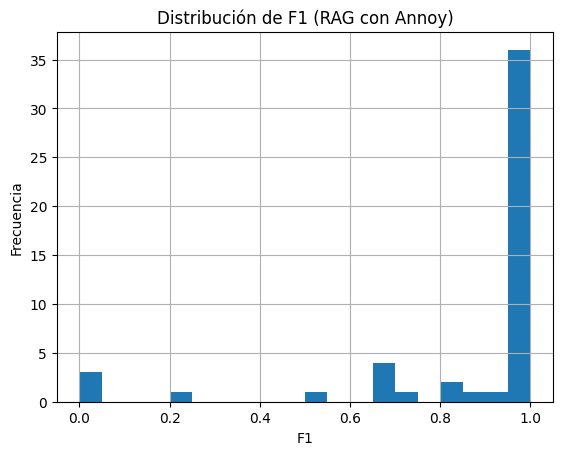

In [9]:
plt.figure()
df_eval['f1'].hist(bins=20)
plt.title('Distribución de F1 (RAG con Annoy)')
plt.xlabel('F1')
plt.ylabel('Frecuencia')
viz_path = '../results/3_rag_qa/f1_hist.png'
plt.savefig(viz_path, bbox_inches='tight')
print('Guardado:', viz_path)
plt.show()